Final Database (got from https://github.com/ignavinuales/Battery_RUL_Prediction/tree/main, they preprocessed the data and created new features)

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

battery = pd.read_csv('Final Database.csv')
battery = battery.drop(columns="Unnamed: 0")
battery.dtypes

Cycle_Index                  float64
Discharge Time (s)           float64
Decrement 3.6-3.4V (s)       float64
Max. Voltage Dischar. (V)    float64
Min. Voltage Charg. (V)      float64
Time at 4.15V (s)            float64
Time constant current (s)    float64
Charging time (s)            float64
Total time (s)               float64
RUL                            int64
dtype: object

Columns:
FEATURE 1: 'Discharge Time (s)' is the time that takes the voltage to reach its minimun value in one discharge cycle.
FEATURE 2: 'Decrement 3.6-3.4V (s)' It represents the time which the voltage takes to drop from 3.6V to 3.4V during a discharge cycle.
FEATURE 3: 'Max. Voltage Dischar. (V)' It's the initial and maximum voltage in the discharging phase.
FEATURE 4: Min. Voltage Charg. (V) It's the initial value of Voltage when charging.
FEATURE 5: 'Time at 4.15V (s)' It's the time to reach 4.15V in charging phase
FEATURE 6: 'Time constant current (s)' It's the time in which the current stays constant at its max. value
FEATURE 7: ('Charging time (s)') It's the total time for charging

# RUL = Last cycle - current cycle

In [21]:
# 1. Summary Statistics
summary_stats = battery.describe()
print(summary_stats)

        Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std      322.378480        33144.012077            15039.589269   
min        1.000000            8.690000          -397645.908000   
25%      271.000000         1169.310000              319.600000   
50%      560.000000         1557.250000              439.239471   
75%      833.000000         1908.000000              600.000000   
max     1134.000000       958320.370000           406703.768000   

       Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
count               15064.000000             15064.000000       15064.000000   
mean                    3.908176                 3.577904        3768.336171   
std                     0.091003                 0.123695        9129.552477   
min                     3.043000                 3.022000        -113.584000

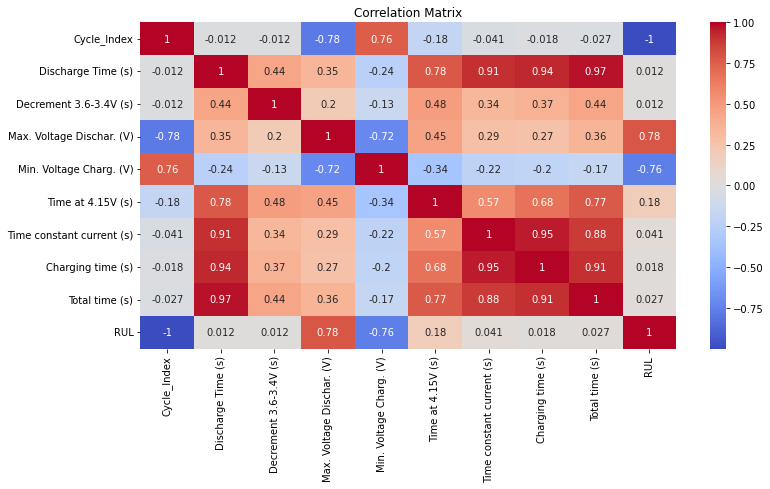

In [19]:
# 2. Correlation Analysis
correlation_matrix = battery.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Text(0, 0.5, 'Cycle')

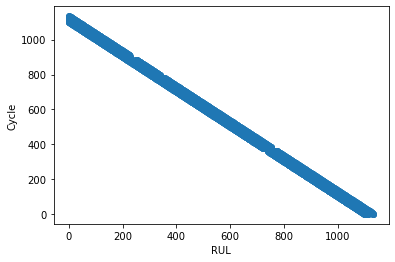

In [23]:
plt.scatter(battery["RUL"], battery["Cycle_Index"])
plt.xlabel("RUL")
plt.ylabel("Cycle")

Text(0, 0.5, 'RUL')

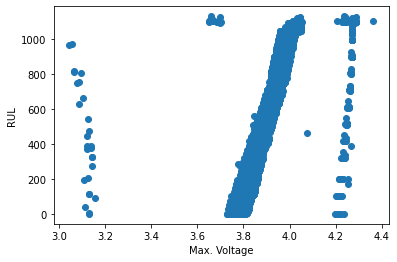

In [27]:
plt.scatter(battery["Max. Voltage Dischar. (V)"], battery["RUL"])
plt.xlabel("Max. Voltage")
plt.ylabel("RUL")

Train-Test

In [29]:
from sklearn.model_selection import train_test_split

# Assuming 'battery' is your DataFrame containing the dataset
# Replace 'target_column' with the name of the column you want to predict (e.g., 'RUL')

X = battery.drop(columns=['RUL',"Cycle_Index"   ])  # Features (all columns except the target)
y = battery['RUL']  # Target variable

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 24302.809698063127


In [31]:
# Get feature importance (coefficients) from the linear regression model
feature_importance = model.coef_

# Create a DataFrame to display the feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                     Feature   Importance
2  Max. Voltage Dischar. (V)  1967.891936
7             Total time (s)     0.005087
4          Time at 4.15V (s)     0.004958
5  Time constant current (s)     0.003807
6          Charging time (s)     0.002616
1     Decrement 3.6-3.4V (s)    -0.000543
0         Discharge Time (s)    -0.013510
3    Min. Voltage Charg. (V) -1195.761925


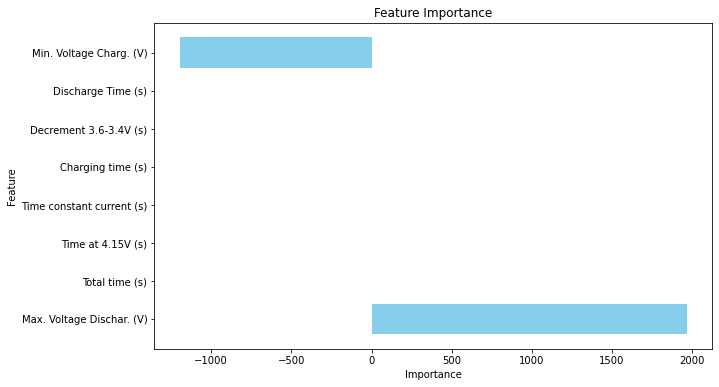

In [32]:
import matplotlib.pyplot as plt

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [33]:
from sklearn.linear_model import Ridge

# Create the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the regularization strength (alpha) as needed

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Mean Squared Error (Ridge Regression):", mse_ridge)


Mean Squared Error (Ridge Regression): 24288.56918579066


In [35]:
from sklearn.linear_model import Lasso

# Create the Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the regularization strength (alpha) as needed

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Mean Squared Error (Lasso Regression):", mse_lasso)


Mean Squared Error (Lasso Regression): 24306.96320456579


In [36]:
from sklearn.preprocessing import PolynomialFeatures

# Create PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=True)  # You can adjust the degree as needed

# Fit and transform the features
X_poly = poly.fit_transform(X)

# Split the transformed features into train and test sets
X_train_poly, X_test_poly, _, _ = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train the model on the transformed features
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_poly = model.predict(X_test_poly)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Mean Squared Error (Model with Polynomial Features):", mse_poly)


Mean Squared Error (Model with Polynomial Features): 468780.68011655065
